In [1]:
import torch
import torch.nn

n_features = 3

In [2]:
def make_data(n_features=n_features, N=1000, eps=0.1, coefs=None, intercept=None):
    coefs = torch.randn(n_features)
    intercept = torch.randn(1)
    noise = torch.randn(N) * eps
    x = torch.rand(N, n_features)
    y = ((coefs * x).sum(dim=1, keepdim=True) +
         intercept.view(1, -1) +
         noise.view(N, -1))
    return x, y, coefs, intercept

In [3]:
x, y, coefs, intercept = make_data()

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

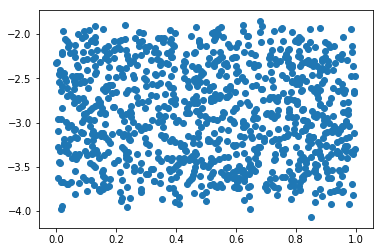

In [5]:
plt.scatter(x[:,0], y);

# Gradient descent

In [6]:
model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.train()

loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    ypred = model(x)
    loss = loss_fn(ypred, y)
    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()

0 10.217625617980957
500 0.07496501505374908
1000 0.025834670290350914
1500 0.014243155717849731
2000 0.01118630263954401
2500 0.010271186009049416
3000 0.009964109398424625
3500 0.009852173738181591
4000 0.00980924628674984
4500 0.009792309254407883


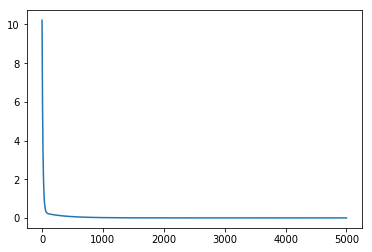

In [7]:
plt.plot(loss_history);

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0514, -0.2796, -1.8383]], requires_grad=True),
 Parameter containing:
 tensor([-1.8270], requires_grad=True)]

In [9]:
print(coefs, intercept)

tensor([-0.0645, -0.2832, -1.8224]) tensor([-1.8248])


# Stochastic gradient descent

In [10]:
%%time 

model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.train()

loss_history = []

for epoch in range(5):
    for xi, yi in zip(x, y):
        optimizer.zero_grad()
        ypred = model(xi)
        loss = loss_fn(ypred, yi)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.041790109127759933
1 0.01649368554353714
2 0.012482975609600544
3 0.011651498265564442
4 0.011456117033958435
CPU times: user 857 ms, sys: 104 ms, total: 961 ms
Wall time: 983 ms


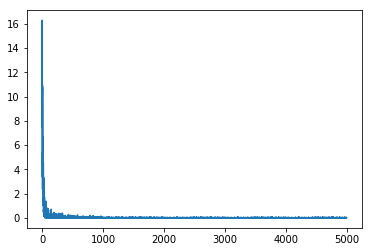

In [11]:
plt.plot(loss_history);

In [12]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0356, -0.2683, -1.8284]], requires_grad=True),
 Parameter containing:
 tensor([-1.8271], requires_grad=True)]

In [13]:
print(coefs, intercept)

tensor([-0.0645, -0.2832, -1.8224]) tensor([-1.8248])


## Minibatches with DataLoader

In [14]:
import torch.utils.data

class LRDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        self.x, self.y, self.coefs, self.intercept = make_data(*args, **kwargs)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [15]:
lrdataloader = torch.utils.data.DataLoader(LRDataset(), batch_size=16, shuffle=True)

In [17]:
x, y = next(iter(lrdataloader))

In [20]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [21]:
type(x), type(y)

(torch.Tensor, torch.Tensor)

In [22]:
x.shape, y.shape

(torch.Size([16, 3]), torch.Size([16, 1]))

In [16]:
%%time 

model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.train()

loss_history = []

for epoch in range(25):
    for xs, ys in lrdataloader:
        optimizer.zero_grad()
        ypred = model(xs)
        loss = loss_fn(ypred, ys)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.018565189093351364
1 0.00856216624379158
2 0.014458323828876019
3 0.012769424356520176
4 0.012126713059842587
5 0.01317200530320406
6 0.012500282377004623
7 0.008144745603203773
8 0.009273579344153404
9 0.00805147085338831
10 0.006821209564805031
11 0.017444495111703873
12 0.007148494478315115
13 0.004906713962554932
14 0.01686525158584118
15 0.0043209632858633995
16 0.013380089774727821
17 0.005124417133629322
18 0.011068979278206825
19 0.015709925442934036
20 0.010643504559993744
21 0.012102878652513027
22 0.009148254059255123
23 0.012785244733095169
24 0.008798872120678425
CPU times: user 553 ms, sys: 41.8 ms, total: 595 ms
Wall time: 588 ms


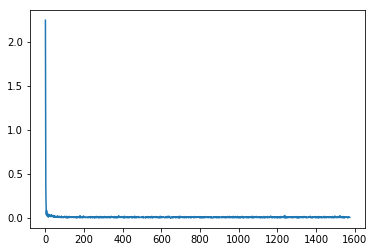

In [17]:
plt.plot(loss_history);

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2498,  0.2622, -0.9163]], requires_grad=True),
 Parameter containing:
 tensor([-1.1182], requires_grad=True)]

In [19]:
print(lrdataloader.dataset.coefs, lrdataloader.dataset.intercept)

tensor([-0.2654,  0.2310, -0.9245]) tensor([-1.1041])
